In [8]:
from ucimlrepo import fetch_ucirepo

# RT-IoT2022 데이터셋 불러오기
rt_iot2022 = fetch_ucirepo(id=942)

# X: 특성 데이터, y: 정답 데이터
X = rt_iot2022.data.features
y = rt_iot2022.data.targets

# 데이터 크기 확인
print("특성 데이터 크기:", X.shape)
print("클래스(공격 종류) 분포:")
print(y.value_counts())


특성 데이터 크기: (123117, 83)
클래스(공격 종류) 분포:
Attack_type               
DOS_SYN_Hping                 94659
Thing_Speak                    8108
ARP_poisioning                 7750
MQTT_Publish                   4146
NMAP_UDP_SCAN                  2590
NMAP_XMAS_TREE_SCAN            2010
NMAP_OS_DETECTION              2000
NMAP_TCP_scan                  1002
DDOS_Slowloris                  534
Wipro_bulb                      253
Metasploit_Brute_Force_SSH       37
NMAP_FIN_SCAN                    28
Name: count, dtype: int64


In [12]:
import pandas as pd

# 특성 예시 보기
print(X.head())

# 'service' 컬럼 안에 어떤 값이 있는지 확인
print("service 컬럼 값들:")
print(X['service'].unique())

# '-'를 "unknown"으로 바꾸기 (경고 없이)
X.loc[:, 'service'] = X['service'].replace("-", "unknown")

# 수치형 컬럼만 추출해보기
X_numeric = X.select_dtypes(include=["int64", "float64"])
print("수치형 특성들:")
print(X_numeric.columns.tolist())

# y 라벨 종류 확인
print("공격/정상 라벨:")
print(y.value_counts())



   id.orig_p  id.resp_p proto service  flow_duration  fwd_pkts_tot  \
0      38667       1883   tcp    mqtt      32.011598             9   
1      51143       1883   tcp    mqtt      31.883584             9   
2      44761       1883   tcp    mqtt      32.124053             9   
3      60893       1883   tcp    mqtt      31.961063             9   
4      51087       1883   tcp    mqtt      31.902362             9   

   bwd_pkts_tot  fwd_data_pkts_tot  bwd_data_pkts_tot  fwd_pkts_per_sec  ...  \
0             5                  3                  3          0.281148  ...   
1             5                  3                  3          0.282277  ...   
2             5                  3                  3          0.280164  ...   
3             5                  3                  3          0.281593  ...   
4             5                  3                  3          0.282111  ...   

    active.avg  active.std     idle.min     idle.max     idle.tot  \
0  2282414.913         0.0  2

In [18]:
from sklearn.model_selection import train_test_split

# 수치형 특성만 사용해 모델을 먼저 만들어봄
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y, test_size=0.2, random_state=42
)

print("훈련 데이터 크기:", X_train.shape)
print("테스트 데이터 크기:", X_test.shape)


훈련 데이터 크기: (98493, 81)
테스트 데이터 크기: (24624, 81)


In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# y_train과 y_test를 1차원으로 변환

y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

# 모델 정의 및 학습
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# 예측 수행
y_pred = model.predict(X_test)

# 평가 지표 출력
print("🎯 혼동 행렬 (Confusion Matrix):")
print(confusion_matrix(y_test, y_pred))

print("\n📊 분류 리포트 (정밀도, 재현율, F1-score):")
print(classification_report(y_test, y_pred))


🎯 혼동 행렬 (Confusion Matrix):
[[ 1571     0     0     0     1     0     0     0     1     0     5     0]
 [    0    97     0     2     0     0     0     0     1     0     0     0]
 [    0     0 18897     0     0     0     0     0     0     0     0     0]
 [    1     0     0   870     0     0     0     0     0     0     0     0]
 [    0     0     0     0     5     0     0     0     1     0     0     0]
 [    0     0     0     0     0     2     0     0     1     0     0     0]
 [    0     0     0     0     0     0   393     0     0     0     0     0]
 [    0     0     0     0     0     0     0   220     0     0     0     0]
 [    4     0     0     0     1     0     0     0   484     0     0     0]
 [    2     0     0     0     0     0     0     0     1   381     0     0]
 [   20     0     0     0     0     0     0     0     2     0  1603     0]
 [    4     0     0     1     0     0     0     0     0     0     0    53]]

📊 분류 리포트 (정밀도, 재현율, F1-score):
                            precision  

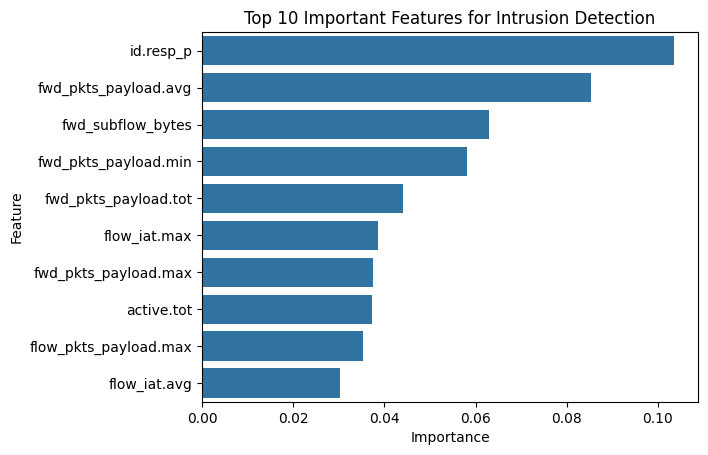

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# 특성 중요도 계산
importances = model.feature_importances_
features = X_numeric.columns
importance_df = pd.DataFrame({'feature': features, 'importance': importances})

# 중요도 상위 10개 시각화
top_features = importance_df.sort_values(by='importance', ascending=False).head(10)

sns.barplot(x='importance', y='feature', data=top_features)
plt.title("Top 10 Important Features for Intrusion Detection")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()


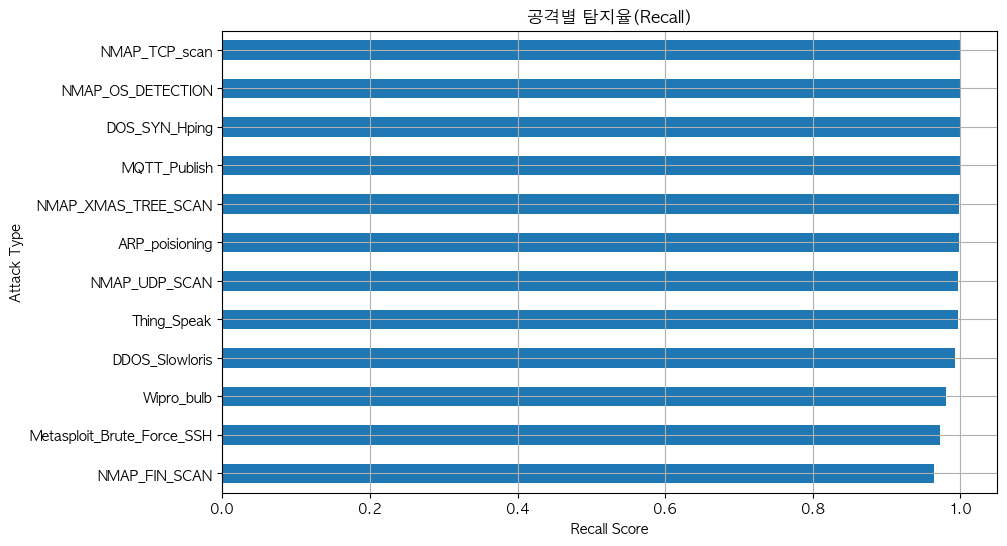

In [34]:
#RECALL 탐지율 시각화
y_pred = model.predict(X_numeric)

from sklearn.metrics import classification_report
report = classification_report(y, y_pred, output_dict=True)

import pandas as pd
import matplotlib.pyplot as plt

df_report = pd.DataFrame(report).T
attack_labels = [label for label in df_report.index if label not in ['accuracy', 'macro avg', 'weighted avg']]

df_report.loc[attack_labels, 'recall'].sort_values().plot(kind='barh', figsize=(10,6))
plt.title("공격별 탐지율(Recall)")
plt.xlabel("Recall Score")
plt.ylabel("Attack Type")
plt.grid(True)
plt.show()


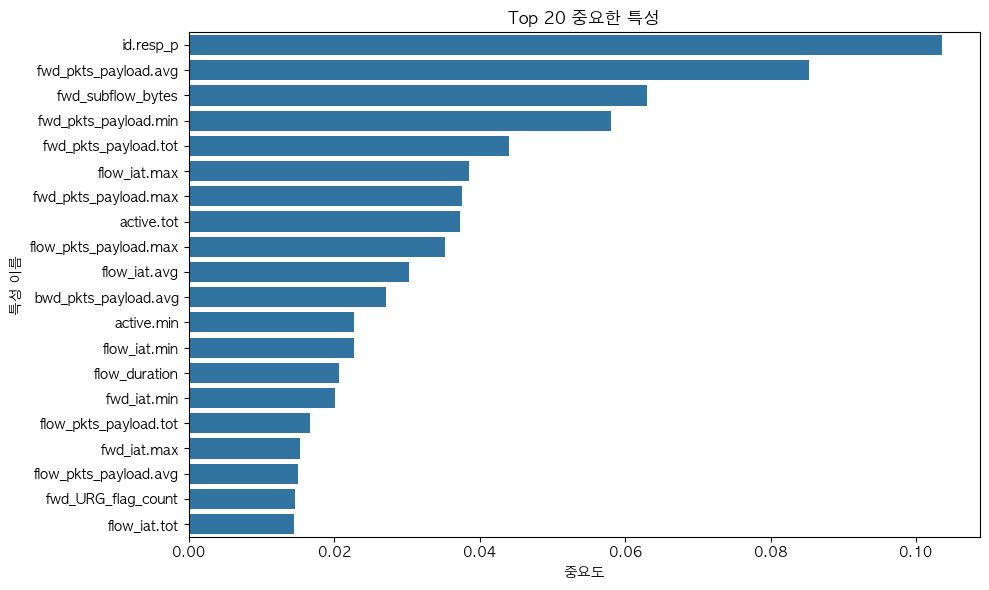

In [36]:
importances = model.feature_importances_

import pandas as pd
feat_df = pd.DataFrame({
    'feature': X_numeric.columns,
    'importance': importances
}).sort_values('importance', ascending=False).head(20)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.barplot(data=feat_df, y='feature', x='importance')
plt.title("Top 20 중요한 특성")
plt.xlabel("중요도")
plt.ylabel("특성 이름")
plt.tight_layout()
plt.show()


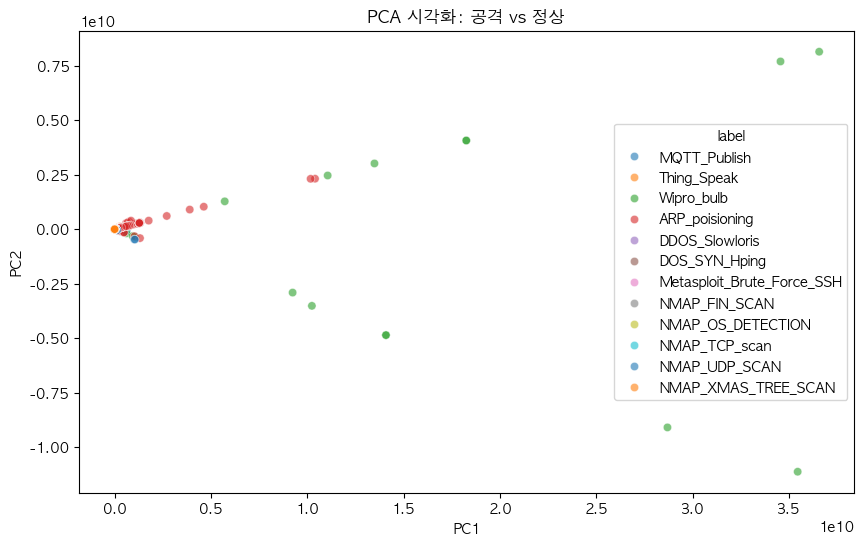

In [40]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# PCA로 차원 축소
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numeric)

# 데이터프레임으로 변환
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['label'] = y.values.ravel()  # ✅ 수정된 부분!

# 시각화
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', alpha=0.6, palette='tab10')
plt.title("PCA 시각화: 공격 vs 정상")
plt.show()



In [42]:
from sklearn.ensemble import IsolationForest

iso_model = IsolationForest(contamination=0.1, random_state=42)
y_pred_iso = iso_model.fit_predict(X_numeric)

# -1: 이상치(공격 추정), 1: 정상 추정
# 라벨 매칭을 위해 변환
y_iso_binary = (y != 'Amazon_Alexa').astype(int)  # 정상: 0, 공격: 1
y_pred_binary = (y_pred_iso == -1).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_iso_binary, y_pred_binary))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.10      0.18    123117

    accuracy                           0.10    123117
   macro avg       0.50      0.05      0.09    123117
weighted avg       1.00      0.10      0.18    123117



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
